# Практична сесія - Аналіз і візуалізація даних на основі OpenStreetMap

Мета: навчитися візуалізувати дані, працювати з геоданими та будувати маршрути на основі реальних картографічних даних.

### Частина 1. Візуалізація даних на основі OpenStreetMap


In [1]:
!pip install osmnx

import osmnx as ox
import matplotlib.pyplot as plt

# Завантаження карти Львова
place_name = "Lviv, Ukraine"
G = ox.graph_from_place(place_name, network_type='drive')

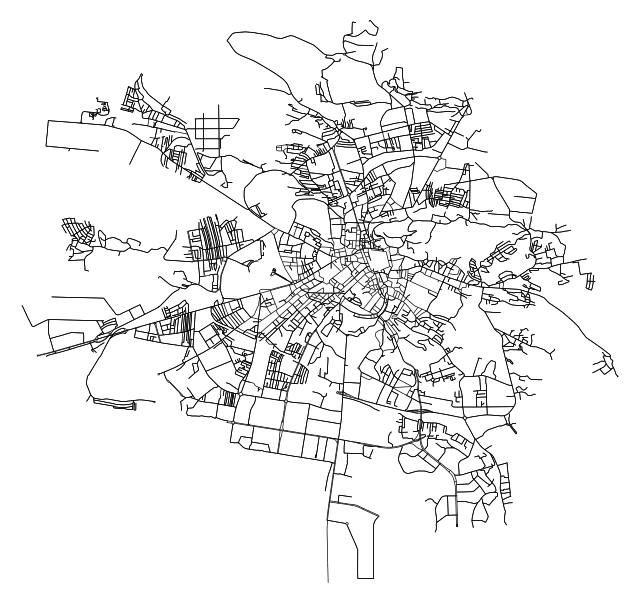

In [2]:
### 1.2 Відобразіть вуличну мережу міста.

fig, ax = ox.plot_graph(G, bgcolor='white', node_color='blue', edge_color='black', node_size=0, edge_linewidth=0.5)
plt.show()

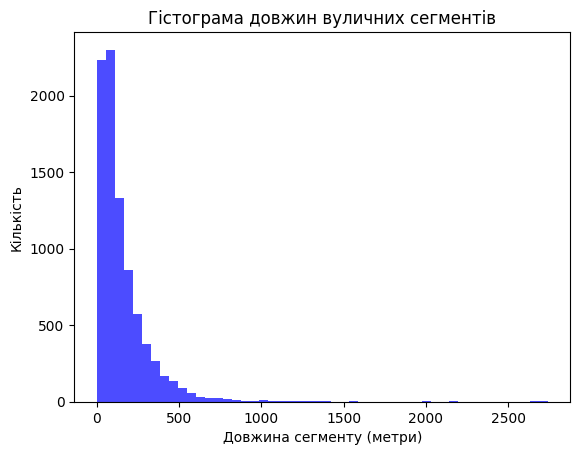

In [3]:
### 1.3 Побудуйте графіки:
### 1.3.1 гістограму довжин вуличних сегментів;

# Отримання довжин вуличних сегментів
edges = ox.graph_to_gdfs(G, nodes=False)
lengths = edges['length']

# Побудова гістограми
plt.hist(lengths, bins=50, color='blue', alpha=0.7)
plt.xlabel('Довжина сегменту (метри)')
plt.ylabel('Кількість')
plt.title('Гістограма довжин вуличних сегментів')
plt.show()

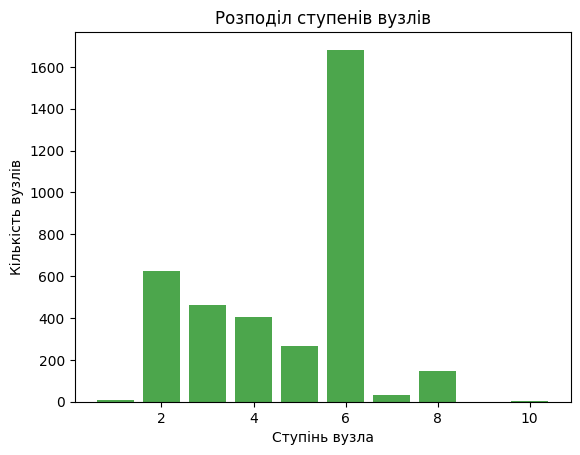

In [4]:
### 1.3.2 Розподіл ступенів вузлів
import pandas as pd

# Обчислення ступенів вузлів
degrees = [degree for node, degree in G.degree()]

# Побудова стовпчикової діаграми
degree_counts = pd.Series(degrees).value_counts().sort_index()
plt.bar(degree_counts.index, degree_counts.values, color='green', alpha=0.7)
plt.xlabel('Ступінь вузла')
plt.ylabel('Кількість вузлів')
plt.title('Розподіл ступенів вузлів')
plt.show()

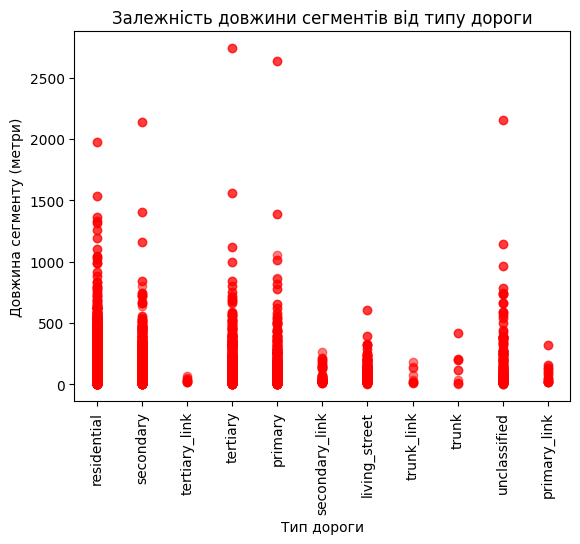

In [5]:
### 1.3.3 Точкова діаграма: довжина vs тип дороги

# Обробка типів доріг (деякі значення можуть бути списками)
edges['highway'] = edges['highway'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Побудова точкової діаграми
plt.scatter(edges['highway'], edges['length'], alpha=0.5, color='red')
plt.xlabel('Тип дороги')
plt.ylabel('Довжина сегменту (метри)')
plt.title('Залежність довжини сегментів від типу дороги')
plt.xticks(rotation=90)
plt.show()

/tmp/ipython-input-6-260490584.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='highway', y='length', data=edges, palette='Set3')


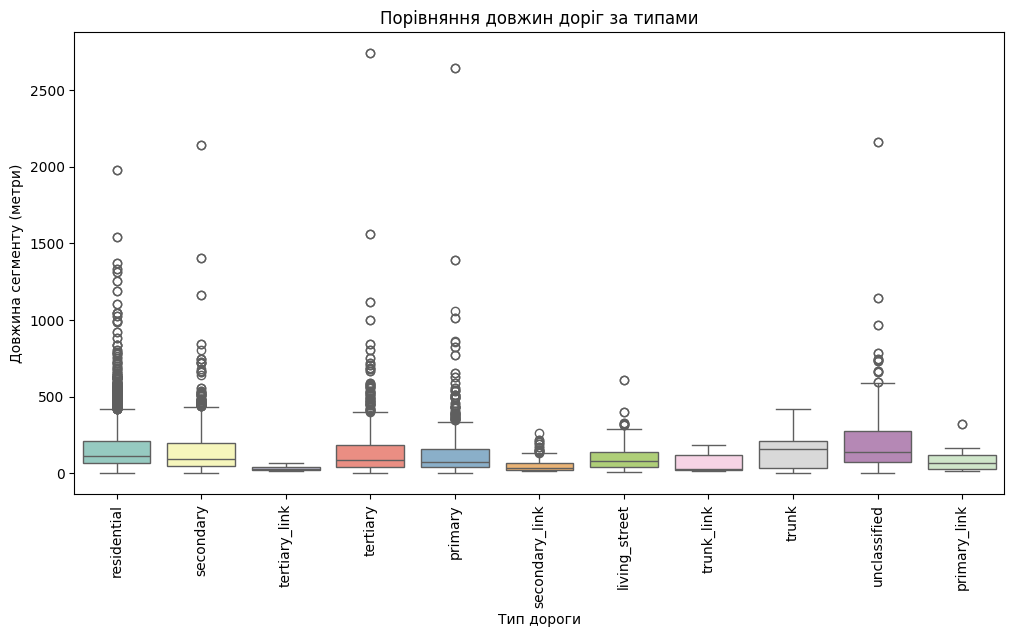

In [6]:
# 1.3.4 Boxplot порівняння довжин за типами
import seaborn as sns

# Побудова boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='highway', y='length', data=edges, palette='Set3')
plt.xlabel('Тип дороги')
plt.ylabel('Довжина сегменту (метри)')
plt.title('Порівняння довжин доріг за типами')
plt.xticks(rotation=90)
plt.show()

# Частина 2. Робота з геоданими
- Завантажте набір просторових даних з OpenStreetMap або створіть його вручну.
- Відобразьте на карті щонайменше три точкові об'єкти (наприклад: вокзал, університет, музей).
- Побудуйте просту карту з геометричними об'єктами на основі координат за допомогою відповідних інструментів.
- Візуалізуйте отримані дані на тлі міської карти.



In [7]:
import folium

# Координати об'єктів (приблизні)
objects = {
    'Вокзал': (49.8406, 24.0156),
    'Університет': (49.8407, 24.0220),
    'Музей': (49.8420, 24.0316)
}

# Створення карти
m = folium.Map(location=[49.8419, 24.0315], zoom_start=14)

# Додавання маркерів
for name, coord in objects.items():
    folium.Marker(location=coord, popup=name).add_to(m)

# Відображення карти в Colab
m

#Частина 3. Побудова маршрутів
- Виберіть два довільні об’єкти на мапі (наприклад, вокзал і театр).
- Побудуйте найкоротший маршрут між ними.
- Відобразіть цей маршрут на карті.
- Побудуйте щонайменше два альтернативні маршрути та порівняйте їх довжину.


In [8]:
import osmnx as ox
import networkx as nx
import itertools
from networkx.algorithms.simple_paths import shortest_simple_paths
import folium


# 2. Перетворюємо MultiDiGraph у простий DiGraph
def to_simple_digraph(G: nx.MultiDiGraph) -> nx.DiGraph:
    DG = nx.DiGraph()
    for u, v, key, data in G.edges(keys=True, data=True):
        length = data.get("length", float("inf"))
        if DG.has_edge(u, v):
            if length < DG[u][v]["length"]:
                DG[u][v]["length"] = length
        else:
            DG.add_edge(u, v, length=length)
    return DG

# 3. Знаходимо k-найкоротших простих шляхів
def get_k_shortest_routes(
    DG: nx.DiGraph, orig: int, dest: int, k: int
) -> list[list[int]]:
    gen = shortest_simple_paths(DG, orig, dest, weight="length")
    return list(itertools.islice(gen, k))

# 4. Обчислюємо довжину маршруту
def compute_length(route: list[int], DG: nx.DiGraph) -> float:
    return sum(DG[u][v]["length"] for u, v in zip(route[:-1], route[1:]))

# 5. Візуалізація трьох маршрутів у Folium (без .save)
def visualize_routes(
    G: nx.MultiDiGraph,
    routes: list[list[int]],
    lengths: list[float],
    points: dict[str, tuple[float, float]]
) -> folium.Map:
    # центр карти
    lats = [lat for lat, lon in points.values()]
    lons = [lon for lat, lon in points.values()]
    center = [sum(lats)/len(lats), sum(lons)/len(lons)]
    m = folium.Map(location=center, zoom_start=15, tiles="CartoDB Positron")

    # маркери старт/фініш
    start_name, end_name = list(points.keys())
    folium.Marker(
        points[start_name], popup=start_name,
        icon=folium.Icon(color="green")
    ).add_to(m)
    folium.Marker(
        points[end_name], popup=end_name,
        icon=folium.Icon(color="blue")
    ).add_to(m)

    # кольори
    colors = ["red", "blue", "green"]
    for idx, route in enumerate(routes):
        coords = [(G.nodes[n]["y"], G.nodes[n]["x"]) for n in route]
        folium.PolyLine(
            locations=coords,
            color=colors[idx],
            weight=4,
            opacity=0.8,
            tooltip=f"Маршрут {idx+1}: {lengths[idx]:.0f} м"
        ).add_to(m)

    # підганяємо bounds під найкоротший маршрут
    coords0 = [(G.nodes[n]["y"], G.nodes[n]["x"]) for n in routes[0]]
    m.fit_bounds(coords0)

    return m


points = {
        "Вокзал": (49.8397, 24.0151),
        "Театр":  (49.8440, 24.0260)
    }
DG = to_simple_digraph(G)

orig = ox.distance.nearest_nodes(G, points["Вокзал"][1], points["Вокзал"][0])
dest = ox.distance.nearest_nodes(G, points["Театр"][1],  points["Театр"][0])

k = 3
routes = get_k_shortest_routes(DG, orig, dest, k)
lengths = [compute_length(r, DG) for r in routes]


# Створюємо інтерактивну Folium-карту
m = visualize_routes(G, routes, lengths, points)
m

In [9]:
# Після обчислення довжин кожного маршруту виводимо:
print(f'Довжина оригінального маршруту: {lengths[0]:.2f} метрів')
print(f'Довжина альтернативного маршруту 2: {lengths[1]:.2f} метрів')
print(f'Довжина альтернативного маршруту 3: {lengths[2]:.2f} метрів')

Довжина оригінального маршруту: 973.81 метрів
Довжина альтернативного маршруту 2: 1019.38 метрів
Довжина альтернативного маршруту 3: 1270.85 метрів


Частина 4. Оптимізація маршруту (задача комівояжера)
- Виберіть 10 історико-культурних об’єктів у місті.
- Розрахуйте оптимальний маршрут, що починається і закінчується на вокзалі та проходить через усі об’єкти.
- Відобразіть цей маршрут на карті міста.
- Порівняйте довжину маршруту з довільним (неоптимізованим) порядком проходження точок.

In [10]:
import osmnx as ox
import networkx as nx
from networkx.algorithms import approximation as approx
import random
import itertools
import folium

# 1. Історико-культурні об’єкти у Львові
objects_10 = {
    "Вокзал":                        (49.8406, 24.0156),
    "Площа Ринок":                   (49.8424, 24.0316),
    "Латинський кафедральний собор": (49.8409, 24.0332),
    "Вірменський собор":             (49.8417, 24.0332),
    "Каплиця Боїмів":                (49.8421, 24.0327),
    "Домініканський собор":          (49.8430, 24.0268),
    "Оперний театр":                 (49.8423, 24.0312),
    "Палац Потоцьких":               (49.84095, 24.02725),
    "Високий Замок":                 (49.84724, 24.03549),
    "Пам'ятник Івану Франку":        (49.83968, 24.02785),
}

# 2. Завантажуємо пішохідний граф Львова
G_walk = ox.graph_from_place("Lviv, Ukraine", network_type="walk")

# 3. Підбираємо найближчі вузли пішохідного графа для кожного POI
nodes_walk = {
    name: ox.distance.nearest_nodes(G_walk, lon, lat)
    for name, (lat, lon) in objects_10.items()
}

# 4. Будуємо повний граф відстаней між POI для пішоходів
tsp_graph = nx.Graph()
for u, v in itertools.combinations(objects_10, 2):
    dist = nx.shortest_path_length(
        G_walk, nodes_walk[u], nodes_walk[v], weight="length"
    )
    tsp_graph.add_edge(u, v, weight=dist)

# 5. Розв’язуємо TSP (Christofides) і повертаємо цикл із стартом/фінішем на вокзалі
cycle = approx.traveling_salesman_problem(
    tsp_graph, cycle=True, weight="weight"
)
i0 = cycle.index("Вокзал")
cycle = cycle[i0:] + cycle[1:i0+1]

# 6. Реконструюємо повний пішохідний маршрут як список вузлів
full_route = []
for a, b in zip(cycle[:-1], cycle[1:]):
    path = nx.shortest_path(G_walk, nodes_walk[a], nodes_walk[b], weight="length")
    full_route.extend(path[:-1])
full_route.append(nodes_walk["Вокзал"])

# 7. Обчислюємо довжину оптимального і випадкового маршрутів
opt_length = sum(
    nx.shortest_path_length(
        G_walk, nodes_walk[a], nodes_walk[b], weight="length"
    )
    for a, b in zip(cycle[:-1], cycle[1:])
)

names = list(objects_10.keys()); names.remove("Вокзал")
rand_seq = ["Вокзал"] + random.sample(names, len(names)) + ["Вокзал"]

rand_length = sum(
    nx.shortest_path_length(
        G_walk, nodes_walk[a], nodes_walk[b], weight="length"
    )
    for a, b in zip(rand_seq[:-1], rand_seq[1:])
)

# 8. Виводимо статистику порівняння
diff = rand_length - opt_length
pct  = diff / rand_length * 100

print(f"Випадковий маршрут:  {rand_length:.0f} м")
print(f"Оптимальний маршрут: {opt_length:.0f} м")
print(f"Економія:            {diff:.0f} м ({pct:.1f}% покращення)")

# 9. Візуалізація обох маршрутів на інтерактивній карті
m = folium.Map(location=objects_10["Вокзал"], zoom_start=13, tiles="CartoDB Positron")

# оптимальний пішохідний маршрут
folium.PolyLine(
    [(G_walk.nodes[n]["y"], G_walk.nodes[n]["x"]) for n in full_route],
    color="green", weight=5, opacity=0.8,
    tooltip=f"Оптимальний: {opt_length:.0f} м"
).add_to(m)

# випадковий пішохідний маршрут
rand_nodes = []
for a, b in zip(rand_seq[:-1], rand_seq[1:]):
    segment = nx.shortest_path(G_walk, nodes_walk[a], nodes_walk[b], weight="length")
    rand_nodes.extend(segment[:-1])
rand_nodes.append(nodes_walk["Вокзал"])

folium.PolyLine(
    [(G_walk.nodes[n]["y"], G_walk.nodes[n]["x"]) for n in rand_nodes],
    color="red", weight=4, opacity=0.6,
    tooltip=f"Випадковий: {rand_length:.0f} м"
).add_to(m)

# маркери для всіх POI
for name, (lat, lon) in objects_10.items():
    folium.Marker(
        [lat, lon],
        popup=name,
        icon=folium.Icon(prefix="fa", icon="walking", color="darkblue")
    ).add_to(m)

m.fit_bounds([(G_walk.nodes[n]["y"], G_walk.nodes[n]["x"]) for n in full_route])
m

Випадковий маршрут:  7009 м
Оптимальний маршрут: 5915 м
Економія:            1093 м (15.6% покращення)


In [11]:
# 9. Порівняння маршрутів: абсолютна і відносна економія
diff = rand_length - opt_length           # на скільки метрів коротший оптимальний
pct  = diff / rand_length * 100           # який відсоток “заощадили”

print(f"Довжина випадкового маршруту:      {rand_length:.0f} м")
print(f"Довжина оптимального маршруту:     {opt_length:.0f} м")
print(f"Економія:                          {diff:.0f} м ({pct:.1f}% покращення)")

Довжина випадкового маршруту:      7009 м
Довжина оптимального маршруту:     5915 м
Економія:                          1093 м (15.6% покращення)


Частина 5.
- Інтерактивна карта (опціонально)
- Створіть інтерактивну карту з маркерами для щонайменше п’яти об’єктів.
- Додайте маршрути та підписи для об’єктів.
- Збережіть або поділіться результатом у вигляді HTML-файлу або скріншотів.



In [26]:
import osmnx as ox
import networkx as nx
import folium
from folium.plugins import MarkerCluster, AntPath
from folium import LayerControl

# 1. Вибір як мінімум 5 POI
objects_10 = {
    "Вокзал":                        (49.8406, 24.0156),
    "Площа Ринок":                   (49.8424, 24.0316),
    "Латинський кафедральний собор": (49.8409, 24.0332),
    "Вірменський собор":             (49.8417, 24.0332),
    "Оперний театр":                 (49.8423, 24.0312),
}

poi_sample = list(objects_10.keys())[:5]

# 2. Завантажуємо пішохідний граф Львова
G_walk = ox.graph_from_place("Lviv, Ukraine", network_type="walk")

# 3. Прив’язуємо POI до вузлів у пішохідному графі
nodes_walk = {
    name: ox.distance.nearest_nodes(G_walk, lon, lat)
    for name, (lat, lon) in objects_10.items()
}

# 4. Розраховуємо маршрути між послідовними POI
walk_routes = []
for a, b in zip(poi_sample[:-1], poi_sample[1:]):
    route = nx.shortest_path(
        G_walk,
        nodes_walk[a],
        nodes_walk[b],
        weight="length"
    )
    walk_routes.append(route)

# 5. Створюємо карту і додаємо шари
m = folium.Map(location=objects_10[poi_sample[0]], zoom_start=14, tiles="CartoDB Positron")

# 5a. Кластер маркерів
cluster = MarkerCluster(name="POI").add_to(m)
for name in poi_sample:
    lat, lon = objects_10[name]
    folium.Marker(
        (lat, lon),
        popup=name,
        tooltip=name,
        icon=folium.Icon(prefix="fa", icon="walking", color="darkgreen")
    ).add_to(cluster)

# 5b. Анімовані пішохідні маршрути
colors = ["#e63946", "#2a9d8f", "#264653", "#f4a261"]
for idx, route in enumerate(walk_routes):
    coords = [(G_walk.nodes[n]["y"], G_walk.nodes[n]["x"]) for n in route]
    AntPath(
        locations=coords,
        color=colors[idx % len(colors)],
        weight=4,
        delay=150,
        tooltip=f"{poi_sample[idx]} → {poi_sample[idx+1]}"
    ).add_to(m)

# 6. Контролер шарів і підганяння bounds
LayerControl().add_to(m)
all_coords = [pt for route in walk_routes for pt in [(G_walk.nodes[n]["y"], G_walk.nodes[n]["x"]) for n in route]]
m.fit_bounds(all_coords)

# 7. Зберігаємо в HTML
m.save("lviv_walk_map.html")
print("Карту збережено у lviv_walk_map.html")

m

Карту збережено у lviv_walk_map.html
